#  测试目标检测性能

In [1]:
!pip install gluoncv

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import gluoncv as gcv
import mxnet as mx

In [2]:
import os

class DetectionDataset(gcv.data.VOCDetection):
    CLASSES = ['cocacola', 'cocacola-zero', 'juice', 'noodles', 'hand']
    def __init__(self, root):
        self._im_shapes = {}
        self._root = os.path.expanduser(root)
        self._transform = None
        self._items = [(self._root, x.strip('.xml')) for x in os.listdir(self._root) if x.endswith('.xml')]
        self._anno_path = os.path.join('{}', '{}.xml')
        self._image_path = os.path.join('{}', '{}.jpg')
        self.index_map = dict(zip(self.classes, range(self.num_class)))
        self._label_cache = self._preload_labels()
        
    def __str__(self):
        detail = self._root
        return self.__class__.__name__ + '(' + detail + ')'
    
    @property
    def classes(self):
        return self.CLASSES
    
    @property
    def num_class(self):
        return len(self.classes)
    
    def get_image_list(self):
        return [os.path.join(x[0], x[1] + '.jpg') for x in self._items]
        
test_dataset = DetectionDataset('../images/v1/test')
print('class_names:', test_dataset.classes)
print('num_images:', len(test_dataset))

class_names: ['cocacola', 'cocacola-zero', 'juice', 'noodles', 'hand']
num_images: 2


# 载入训练好的模型

In [3]:
net = gcv.model_zoo.get_model('ssd_512_resnet50_v1_custom', classes=test_dataset.classes, pretrained_base=False)
param_files = ([x for x in os.listdir('.') if x.endswith('.params')])
selected = param_files[0]
print('磁盘上有训练好的模型：', param_files)
net.load_parameters(selected)
print('载入完毕:', selected)

磁盘上有训练好的模型： ['object_detector_epoch200_10_22_2019_00_24_40.params']
载入完毕: object_detector_epoch200_10_22_2019_00_24_40.params


# 观察检测性能

In [4]:
images = test_dataset.get_image_list()
print('测试图像集：', images)

测试图像集： ['../images/v1/test/frame_1571435703.4214327.jpg', '../images/v1/test/frame_1571435739.1187956.jpg']


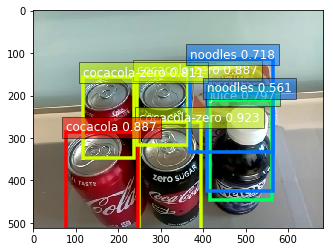

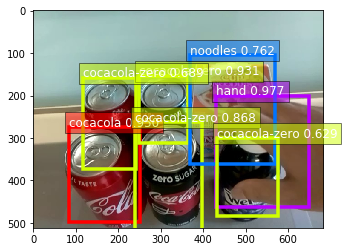

CPU times: user 3.25 s, sys: 273 ms, total: 3.52 s
Wall time: 1.56 s


In [6]:
%%time
from matplotlib import pyplot as plt
# Use GPU
# ctx = mx.gpu(0)
ctx = mx.cpu(0)
net.collect_params().reset_ctx(ctx)
for image in images:
    x, img = gcv.data.transforms.presets.ssd.load_test(image, short=512)
    class_IDs, scores, bounding_boxes = net(x.as_in_context(ctx))
    ax = gcv.utils.viz.plot_bbox(img, bounding_boxes[0], scores[0],
                         class_IDs[0], class_names=net.classes)
    plt.show()

# 测试结果总结

In [8]:
import time
from tqdm import tqdm
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.ssd import SSDDefaultValTransform

def validate(net, test_dataset, ctx):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    size = len(test_dataset)
    metric = gcv.utils.metrics.voc_detection.VOC07MApMetric(iou_thresh=0.5, class_names=test_dataset.classes)
    net.collect_params().reset_ctx(ctx)
    metric.reset()
    width, height = 512, 512
    batch_size = 4
    batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
    val_loader = mx.gluon.data.DataLoader(
        test_dataset.transform(SSDDefaultValTransform(width, height)), batchify_fn=batchify_fn,
        batch_size=batch_size, shuffle=False, last_batch='rollover', num_workers=0)
    with tqdm(total=size) as pbar:
        start = time.time()
        for ib, batch in enumerate(val_loader):
            data = mx.gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
            label = mx.gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
            det_bboxes = []
            det_ids = []
            det_scores = []
            gt_bboxes = []
            gt_ids = []
            gt_difficults = []
            for x, y in zip(data, label):
                ids, scores, bboxes = net(x)
                det_ids.append(ids)
                det_scores.append(scores)
                # clip to image size
                det_bboxes.append(bboxes.clip(0, batch[0].shape[2]))
                # split ground truths
                gt_ids.append(y.slice_axis(axis=-1, begin=4, end=5))
                gt_bboxes.append(y.slice_axis(axis=-1, begin=0, end=4))
                gt_difficults.append(y.slice_axis(axis=-1, begin=5, end=6) if y.shape[-1] > 5 else None)

            metric.update(det_bboxes, det_ids, det_scores, gt_bboxes, gt_ids, gt_difficults)
            pbar.update(batch[0].shape[0])
        end = time.time()
        speed = size / (end - start)
        print('Throughput is %f img/sec.'% speed)
    return metric.get()

final_result = validate(net, test_dataset, mx.gpu(0))

  0%|          | 0/2 [00:00<?, ?it/s]

Throughput is 71697.504274 img/sec.


ValueError: max() arg is an empty sequence

In [7]:
for name, score in zip(*final_result):
    print(name, ':', score)

d2l : 0.8368060224837719
mAP : 0.8368060224837719
